### Using KDiffusion model, baseline

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['OMP_NUM_THREADS']='1'

In [2]:
!pip install -q diffusers datasets wandb lpips timm

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: jantic. Use `wandb login --relogin` to force relogin


True

In [4]:
#@title imports
import wandb
import torch
import torchvision
from torch import nn
from torch import multiprocessing as mp
from torch.utils import data
from torchvision import datasets, transforms
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
from timm.optim.rmsprop_tf import RMSpropTF
from timm.optim.lookahead import Lookahead
import accelerate
from einops import rearrange
from functools import partial
import math
from copy import deepcopy
from pathlib import Path
from tqdm.auto import trange, tqdm
import k_diffusion as K
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cuda


In [5]:
def RmsLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    rmsprop = RMSpropTF(params, *args, **kwargs)
    return Lookahead(rmsprop, alpha, k)

In [6]:
#Training Config
bs = 256 # the batch size
grad_accum_steps = 1 # the number of gradient accumulation steps
lr_max = 4e-4 # the max learning rate
num_workers = 8 # the number of data loader workers
resume = None # the checkpoint to resume from
save_every = 10000 # save every this many steps
training_seed = None # the random seed for training
start_method = 'spawn' # the multiprocessing start method. Options: 'fork', 'forkserver', 'spawn'
opt_func = partial(torch.optim.AdamW, lr=lr_max, betas=(0.95, 0.999),
                  eps=1e-6, weight_decay=1e-3) 

#opt_func = partial(RmsLookahead, lr=lr_max, weight_decay=1e-3) 

#Logging Config
sample_n = 64 # the number of images to sample for demo grids
demo_every = 250 # save a demo grid every this many steps
evaluate_every = 10000 # save a demo grid every this many steps
evaluate_n = 50000 # the number of samples to draw to evaluate
name = 'KDiff_CelebA_Baseline' # the name of the run
wandb_project = 'FastDiffusion_KDiff_CelebA' # the wandb project name (specify this to enable wandb)
wandb_save_model = False # save model to wandb
dataset_name = 'CelebA' # wandb name for dataset used
comments = 'Baseline run of K-diffusion model on CelebA.' # comments logged in wandb
demo_imgs_dir = './demo_images'
metrics_dir = './metrics'

#Model Config
sz = 64
size = [sz,sz]
input_channels = 3
patch_size= 1
mapping_out= 256
depths= [2, 4, 4]
channels= [128, 256, 512]
self_attn_depths = [False, False, True]
cross_attn_depths = None
has_variance = True
dropout_rate = 0.05
augment_wrapper = True
augment_prob = 0.12
sigma_data = 0.5
sigma_min = 1e-2
sigma_max = 80
skip_stages = 0
augment_prob = 0.12
sigma_min = 1e-2
sigma_max = 80

#Model Save/Load
checkpoints_dir = './checkpoints'
model_path = Path(checkpoints_dir +'/' + name + '.pt')
model_ema_path = Path(checkpoints_dir +'/' + name + '_ema.pt')
model_path.parent.mkdir(exist_ok=True)

In [7]:
mp.set_start_method(start_method)
torch.backends.cuda.matmul.allow_tf32 = True

In [8]:
ddp_kwargs = accelerate.DistributedDataParallelKwargs(find_unused_parameters=skip_stages > 0)
accelerator = accelerate.Accelerator(kwargs_handlers=[ddp_kwargs], gradient_accumulation_steps=grad_accum_steps)
device = accelerator.device
print(f'Process {accelerator.process_index} using device: {device}', flush=True)

Process 0 using device: cuda


# Model and Training Setup

In [9]:
def make_sample_density(mean=-1.2, std=1.2):
    #lognormal
    return partial(K.utils.rand_log_normal, loc=mean, scale=std)

In [10]:
def make_model():
    model = K.models.ImageDenoiserModelV1(
        c_in=input_channels,
        feats_in=mapping_out,
        depths=depths,
        channels=channels,
        self_attn_depths=self_attn_depths,
        cross_attn_depths=cross_attn_depths,
        patch_size=patch_size,
        dropout_rate=dropout_rate,
        mapping_cond_dim= 9 if augment_wrapper else 0,
        unet_cond_dim = 0,
        cross_cond_dim = 0,
        skip_stages= skip_stages,
        has_variance=has_variance,
    )
    if augment_wrapper:
        model = K.augmentation.KarrasAugmentWrapper(model)
    return model

In [11]:
def make_denoiser_wrapper():
    if not has_variance:
        return partial(K.layers.Denoiser, sigma_data=sigma_data)
    return partial(K.layers.DenoiserWithVariance, sigma_data=sigma_data)

In [12]:
tfm = transforms.Compose([
    transforms.Resize(sz, interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.CenterCrop(sz),
    K.augmentation.KarrasAugmentationPipeline(augment_prob),
])

def tfms(examples):
    examples["image"] = [tfm(image.convert("RGB")) for image in examples["image"]]
    return examples

In [13]:
training_set = load_dataset('huggan/CelebA-faces')
tds = training_set.with_transform(tfms)['train']
dls = DataLoaders.from_dsets(tds, bs)
train_dl = dls.train

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (F:/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [14]:
inner_model = make_model()

if accelerator.is_main_process:
    print('Parameters:', K.utils.n_params(inner_model))

model = make_denoiser_wrapper()(inner_model)

Parameters: 63226756


In [15]:
def init_wandb():
    import wandb
    log_config = {}
    log_config['num_epochs'] = 'N/A'
    log_config['lr_max'] = lr_max
    log_config['comments'] = comments
    log_config['dataset'] = dataset_name
    log_config['parameters'] = K.utils.n_params(inner_model)
    wandb.init(project=wandb_project, config=log_config, save_code=False)    

In [16]:
def init_training_manual_seed(accelerator):
    if training_seed is not None:
        seeds = torch.randint(-2 ** 63, 2 ** 63 - 1, [accelerator.num_processes], generator=torch.Generator().manual_seed(training_seed))
        torch.manual_seed(seeds[accelerator.process_index])    

In [17]:
def log_step_to_wandb(epoch, loss, step, sched, ema_decay):
    log_dict = {
        'epoch': epoch,
        'loss': loss.item(),
        'lr': sched.get_last_lr()[0],
        'ema_decay': ema_decay,
    }
    wandb.log(log_dict, step=step)

In [18]:
def write_progress_to_tdqm(epoch, step, loss):
    tqdm.write(f'Epoch: {epoch}, step: {step}, loss: {loss.item():g}')

In [19]:
opt = opt_func(inner_model.parameters())
init_training_manual_seed(accelerator)
use_wandb = accelerator.is_main_process and wandb_project
if use_wandb: init_wandb()
sched = K.utils.InverseLR(opt, inv_gamma=20000.0, power=1.0, warmup=0.99)
ema_sched = K.utils.EMAWarmup(power=0.6667, max_value=0.9999)
image_key = 'image'

inner_model, opt, train_dl = accelerator.prepare(inner_model, opt, train_dl)
if use_wandb:
    wandb.watch(inner_model)

sample_density = make_sample_density()
model_ema = deepcopy(model)

epoch = 0
step = 0

In [20]:
evaluate_enabled = evaluate_every > 0 and evaluate_n > 0
extractor = None

if evaluate_enabled:
    extractor = K.evaluation.InceptionV3FeatureExtractor(device=device)
    train_iter = iter(train_dl)
    if accelerator.is_main_process:
        print('Computing features for reals...')
    reals_features = K.evaluation.compute_features(accelerator, lambda x: next(train_iter)[image_key][1].to(device), extractor, evaluate_n, bs)
    if accelerator.is_main_process:
        Path(metrics_dir).mkdir(exist_ok=True)
        metrics_log = K.utils.CSVLogger(f'{name}_metrics.csv', ['step', 'fid', 'kid'])
    del train_iter

Computing features for reals...


  0%|          | 0/196 [00:00<?, ?it/s]

In [21]:
@torch.no_grad()
def demo(model_ema, step, size):
    with K.utils.eval_mode(model_ema):
        if accelerator.is_main_process:
            tqdm.write('Sampling...')
        filename = f'{demo_imgs_dir}/{name}_demo_{step:08}.png'
        path = Path(filename)
        path.parent.mkdir(exist_ok=True)
        n_per_proc = math.ceil(sample_n / accelerator.num_processes)
        x = torch.randn([n_per_proc, input_channels, size[0], size[1]], device=device) * sigma_max
        sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
        x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=not accelerator.is_main_process)
        x_0 = accelerator.gather(x_0)[:sample_n]
        # For some reason the images are inverting...
        #x_0 = -x_0

        if accelerator.is_main_process:
            grid = torchvision.utils.make_grid(x_0, nrow=math.ceil(sample_n ** 0.5), padding=0)
            K.utils.to_pil_image(grid).save(filename)
            if use_wandb:
                wandb.log({'demo_grid': wandb.Image(filename)}, step=step)

In [22]:
@torch.no_grad()
def evaluate(model_ema, step, size):
    with K.utils.eval_mode(model_ema):
        if not evaluate_enabled:
            return
        if accelerator.is_main_process:
            tqdm.write('Evaluating...')
        sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
        def sample_fn(n):
            x = torch.randn([n, input_channels, size[0], size[1]], device=device) * sigma_max
            x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=True)
            return x_0
        fakes_features = K.evaluation.compute_features(accelerator, sample_fn, extractor, evaluate_n, bs)
        if accelerator.is_main_process:
            fid = K.evaluation.fid(fakes_features, reals_features)
            kid = K.evaluation.kid(fakes_features, reals_features)
            print(f'FID: {fid.item():g}, KID: {kid.item():g}')
            if accelerator.is_main_process:
                metrics_log.write(step, fid.item(), kid.item())
            if use_wandb:
                wandb.log({'FID': fid.item(), 'KID': kid.item()}, step=step)

In [23]:
def save(step, epoch, opt, sched):
    accelerator.wait_for_everyone()
    filename = f'{checkpoints_dir}/{name}_{step:08}.pth'
    if accelerator.is_main_process:
        tqdm.write(f'Saving to {filename}...')
    obj = {
        'model': accelerator.unwrap_model(model.inner_model).state_dict(),
        'model_ema': accelerator.unwrap_model(model_ema.inner_model).state_dict(),
        'opt': opt.state_dict(),
        'sched': sched.state_dict(),
        'ema_sched': ema_sched.state_dict(),
        'epoch': epoch,
        'step': step
    }
    accelerator.save(obj, filename)

## Training Loop

In [24]:
try:
    while True:
        for batch in tqdm(train_dl, disable=not accelerator.is_main_process):
            with accelerator.accumulate(model):
                reals, _, aug_cond = batch[image_key]
                reals = reals.to(device)
                aug_cond = aug_cond.to(device)
                noise = torch.randn_like(reals)
                sigma = sample_density([reals.shape[0]], device=device)
                losses = model.loss(reals, noise, sigma, aug_cond=aug_cond)
                losses_all = accelerator.gather(losses)
                loss = losses_all.mean()
                accelerator.backward(losses.mean())
                opt.step()
                sched.step()
                opt.zero_grad()
                if accelerator.sync_gradients:
                    ema_decay = ema_sched.get_value()
                    K.utils.ema_update(model, model_ema, ema_decay)
                    ema_sched.step()

            if accelerator.is_main_process and step % 25 == 0:
                write_progress_to_tdqm(epoch, step, loss)

            if use_wandb: 
                log_step_to_wandb(epoch, loss, step, sched, ema_decay)

            if step % demo_every == 0:
                demo(model_ema, step, size)

            if evaluate_enabled and step > 0 and step % evaluate_every == 0:
                evaluate(model_ema, step, size)

            if step > 0 and step % save_every == 0:
                save(step, epoch, opt, sched)

            step += 1
        epoch += 1
except KeyboardInterrupt:
    pass

  0%|          | 0/3165 [00:00<?, ?it/s]

Epoch: 0, step: 0, loss: 0.59679
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 25, loss: 0.458975
Epoch: 0, step: 50, loss: 0.363365
Epoch: 0, step: 75, loss: 0.281771
Epoch: 0, step: 100, loss: 0.115373
Epoch: 0, step: 125, loss: -0.0898514
Epoch: 0, step: 150, loss: -0.248896
Epoch: 0, step: 175, loss: -0.291538
Epoch: 0, step: 200, loss: -0.310364
Epoch: 0, step: 225, loss: -0.296068
Epoch: 0, step: 250, loss: -0.356758
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 275, loss: -0.342862
Epoch: 0, step: 300, loss: -0.337221
Epoch: 0, step: 325, loss: -0.385334
Epoch: 0, step: 350, loss: -0.415827
Epoch: 0, step: 375, loss: -0.420381
Epoch: 0, step: 400, loss: -0.403853
Epoch: 0, step: 425, loss: -0.321009
Epoch: 0, step: 450, loss: -0.412922
Epoch: 0, step: 475, loss: -0.376554
Epoch: 0, step: 500, loss: -0.393707
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 525, loss: -0.427299
Epoch: 0, step: 550, loss: -0.402043
Epoch: 0, step: 575, loss: -0.375002
Epoch: 0, step: 600, loss: -0.392801
Epoch: 0, step: 625, loss: -0.45492
Epoch: 0, step: 650, loss: -0.469266
Epoch: 0, step: 675, loss: -0.480935
Epoch: 0, step: 700, loss: -0.530784
Epoch: 0, step: 725, loss: -0.489127
Epoch: 0, step: 750, loss: -0.492383
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 775, loss: -0.470382
Epoch: 0, step: 800, loss: -0.463067
Epoch: 0, step: 825, loss: -0.526731
Epoch: 0, step: 850, loss: -0.486552
Epoch: 0, step: 875, loss: -0.495446
Epoch: 0, step: 900, loss: -0.512851
Epoch: 0, step: 925, loss: -0.491055
Epoch: 0, step: 950, loss: -0.522601
Epoch: 0, step: 975, loss: -0.501576
Epoch: 0, step: 1000, loss: -0.46701
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1025, loss: -0.549725
Epoch: 0, step: 1050, loss: -0.546062
Epoch: 0, step: 1075, loss: -0.529283
Epoch: 0, step: 1100, loss: -0.449387
Epoch: 0, step: 1125, loss: -0.507235
Epoch: 0, step: 1150, loss: -0.451941
Epoch: 0, step: 1175, loss: -0.533387
Epoch: 0, step: 1200, loss: -0.493911
Epoch: 0, step: 1225, loss: -0.493213
Epoch: 0, step: 1250, loss: -0.479984
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1275, loss: -0.482113
Epoch: 0, step: 1300, loss: -0.528397
Epoch: 0, step: 1325, loss: -0.482449
Epoch: 0, step: 1350, loss: -0.509009
Epoch: 0, step: 1375, loss: -0.530613
Epoch: 0, step: 1400, loss: -0.541206
Epoch: 0, step: 1425, loss: -0.560316
Epoch: 0, step: 1450, loss: -0.524175
Epoch: 0, step: 1475, loss: -0.499953
Epoch: 0, step: 1500, loss: -0.554522
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1525, loss: -0.490172
Epoch: 0, step: 1550, loss: -0.498581
Epoch: 0, step: 1575, loss: -0.532473
Epoch: 0, step: 1600, loss: -0.485635
Epoch: 0, step: 1625, loss: -0.530915
Epoch: 0, step: 1650, loss: -0.532642
Epoch: 0, step: 1675, loss: -0.584894
Epoch: 0, step: 1700, loss: -0.512707
Epoch: 0, step: 1725, loss: -0.539463
Epoch: 0, step: 1750, loss: -0.541614
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 1775, loss: -0.578725
Epoch: 0, step: 1800, loss: -0.530164
Epoch: 0, step: 1825, loss: -0.513274
Epoch: 0, step: 1850, loss: -0.52225
Epoch: 0, step: 1875, loss: -0.506665
Epoch: 0, step: 1900, loss: -0.563619
Epoch: 0, step: 1925, loss: -0.500135
Epoch: 0, step: 1950, loss: -0.634
Epoch: 0, step: 1975, loss: -0.563381
Epoch: 0, step: 2000, loss: -0.50427
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 2025, loss: -0.619292
Epoch: 0, step: 2050, loss: -0.539611
Epoch: 0, step: 2075, loss: -0.549114
Epoch: 0, step: 2100, loss: -0.554548
Epoch: 0, step: 2125, loss: -0.57366
Epoch: 0, step: 2150, loss: -0.504198
Epoch: 0, step: 2175, loss: -0.585339
Epoch: 0, step: 2200, loss: -0.547479
Epoch: 0, step: 2225, loss: -0.591351
Epoch: 0, step: 2250, loss: -0.52011
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 2275, loss: -0.56292
Epoch: 0, step: 2300, loss: -0.559072
Epoch: 0, step: 2325, loss: -0.521584
Epoch: 0, step: 2350, loss: -0.53724
Epoch: 0, step: 2375, loss: -0.490209
Epoch: 0, step: 2400, loss: -0.533626
Epoch: 0, step: 2425, loss: -0.565715
Epoch: 0, step: 2450, loss: -0.571924
Epoch: 0, step: 2475, loss: -0.562968
Epoch: 0, step: 2500, loss: -0.539268
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 2525, loss: -0.564859
Epoch: 0, step: 2550, loss: -0.512631
Epoch: 0, step: 2575, loss: -0.560648
Epoch: 0, step: 2600, loss: -0.493394
Epoch: 0, step: 2625, loss: -0.615551
Epoch: 0, step: 2650, loss: -0.535129
Epoch: 0, step: 2675, loss: -0.524503
Epoch: 0, step: 2700, loss: -0.538717
Epoch: 0, step: 2725, loss: -0.569157
Epoch: 0, step: 2750, loss: -0.588678
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 2775, loss: -0.569082
Epoch: 0, step: 2800, loss: -0.56233
Epoch: 0, step: 2825, loss: -0.577273
Epoch: 0, step: 2850, loss: -0.483576
Epoch: 0, step: 2875, loss: -0.57795
Epoch: 0, step: 2900, loss: -0.519856
Epoch: 0, step: 2925, loss: -0.524642
Epoch: 0, step: 2950, loss: -0.583305
Epoch: 0, step: 2975, loss: -0.544663
Epoch: 0, step: 3000, loss: -0.558913
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, step: 3025, loss: -0.590865
Epoch: 0, step: 3050, loss: -0.538943
Epoch: 0, step: 3075, loss: -0.583543
Epoch: 0, step: 3100, loss: -0.55064
Epoch: 0, step: 3125, loss: -0.525858
Epoch: 0, step: 3150, loss: -0.553091


  0%|          | 0/3165 [00:00<?, ?it/s]

Epoch: 1, step: 3175, loss: -0.63993
Epoch: 1, step: 3200, loss: -0.588744
Epoch: 1, step: 3225, loss: -0.56982
Epoch: 1, step: 3250, loss: -0.475931
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 3275, loss: -0.593077
Epoch: 1, step: 3300, loss: -0.619762
Epoch: 1, step: 3325, loss: -0.606327
Epoch: 1, step: 3350, loss: -0.584061
Epoch: 1, step: 3375, loss: -0.528335
Epoch: 1, step: 3400, loss: -0.624975
Epoch: 1, step: 3425, loss: -0.574009
Epoch: 1, step: 3450, loss: -0.589153
Epoch: 1, step: 3475, loss: -0.580525
Epoch: 1, step: 3500, loss: -0.622918
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 3525, loss: -0.551902
Epoch: 1, step: 3550, loss: -0.596326
Epoch: 1, step: 3575, loss: -0.567699
Epoch: 1, step: 3600, loss: -0.597291
Epoch: 1, step: 3625, loss: -0.605007
Epoch: 1, step: 3650, loss: -0.576742
Epoch: 1, step: 3675, loss: -0.503572
Epoch: 1, step: 3700, loss: -0.496392
Epoch: 1, step: 3725, loss: -0.540575
Epoch: 1, step: 3750, loss: -0.610023
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 3775, loss: -0.591742
Epoch: 1, step: 3800, loss: -0.597212
Epoch: 1, step: 3825, loss: -0.584597
Epoch: 1, step: 3850, loss: -0.577423
Epoch: 1, step: 3875, loss: -0.59521
Epoch: 1, step: 3900, loss: -0.603453
Epoch: 1, step: 3925, loss: -0.584362
Epoch: 1, step: 3950, loss: -0.530956
Epoch: 1, step: 3975, loss: -0.578509
Epoch: 1, step: 4000, loss: -0.565592
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 4025, loss: -0.582589
Epoch: 1, step: 4050, loss: -0.584855
Epoch: 1, step: 4075, loss: -0.555067
Epoch: 1, step: 4100, loss: -0.601426
Epoch: 1, step: 4125, loss: -0.569101
Epoch: 1, step: 4150, loss: -0.609833
Epoch: 1, step: 4175, loss: -0.549561
Epoch: 1, step: 4200, loss: -0.661714
Epoch: 1, step: 4225, loss: -0.581706
Epoch: 1, step: 4250, loss: -0.561809
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 4275, loss: -0.588669
Epoch: 1, step: 4300, loss: -0.590651
Epoch: 1, step: 4325, loss: -0.602147
Epoch: 1, step: 4350, loss: -0.616007
Epoch: 1, step: 4375, loss: -0.553802
Epoch: 1, step: 4400, loss: -0.546446
Epoch: 1, step: 4425, loss: -0.532656
Epoch: 1, step: 4450, loss: -0.569096
Epoch: 1, step: 4475, loss: -0.578217
Epoch: 1, step: 4500, loss: -0.587386
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 4525, loss: -0.621157
Epoch: 1, step: 4550, loss: -0.631519
Epoch: 1, step: 4575, loss: -0.574315
Epoch: 1, step: 4600, loss: -0.533177
Epoch: 1, step: 4625, loss: -0.570514
Epoch: 1, step: 4650, loss: -0.528092
Epoch: 1, step: 4675, loss: -0.544418
Epoch: 1, step: 4700, loss: -0.61174
Epoch: 1, step: 4725, loss: -0.634222
Epoch: 1, step: 4750, loss: -0.585981
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 4775, loss: -0.591792
Epoch: 1, step: 4800, loss: -0.579572
Epoch: 1, step: 4825, loss: -0.593395
Epoch: 1, step: 4850, loss: -0.618275
Epoch: 1, step: 4875, loss: -0.55759
Epoch: 1, step: 4900, loss: -0.610729
Epoch: 1, step: 4925, loss: -0.612488
Epoch: 1, step: 4950, loss: -0.6524
Epoch: 1, step: 4975, loss: -0.570576
Epoch: 1, step: 5000, loss: -0.567754
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 5025, loss: -0.5915
Epoch: 1, step: 5050, loss: -0.593916
Epoch: 1, step: 5075, loss: -0.635612
Epoch: 1, step: 5100, loss: -0.588703
Epoch: 1, step: 5125, loss: -0.641333
Epoch: 1, step: 5150, loss: -0.542372
Epoch: 1, step: 5175, loss: -0.587812
Epoch: 1, step: 5200, loss: -0.616954
Epoch: 1, step: 5225, loss: -0.555096
Epoch: 1, step: 5250, loss: -0.632669
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 5275, loss: -0.634601
Epoch: 1, step: 5300, loss: -0.555083
Epoch: 1, step: 5325, loss: -0.608524
Epoch: 1, step: 5350, loss: -0.607606
Epoch: 1, step: 5375, loss: -0.54083
Epoch: 1, step: 5400, loss: -0.567304
Epoch: 1, step: 5425, loss: -0.582144
Epoch: 1, step: 5450, loss: -0.614638
Epoch: 1, step: 5475, loss: -0.589444
Epoch: 1, step: 5500, loss: -0.613581
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 5525, loss: -0.567969
Epoch: 1, step: 5550, loss: -0.582954
Epoch: 1, step: 5575, loss: -0.574785
Epoch: 1, step: 5600, loss: -0.570074
Epoch: 1, step: 5625, loss: -0.592746
Epoch: 1, step: 5650, loss: -0.559596
Epoch: 1, step: 5675, loss: -0.543313
Epoch: 1, step: 5700, loss: -0.555795
Epoch: 1, step: 5725, loss: -0.561269
Epoch: 1, step: 5750, loss: -0.626091
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 5775, loss: -0.591995
Epoch: 1, step: 5800, loss: -0.584118
Epoch: 1, step: 5825, loss: -0.566009
Epoch: 1, step: 5850, loss: -0.625487
Epoch: 1, step: 5875, loss: -0.622654
Epoch: 1, step: 5900, loss: -0.557918
Epoch: 1, step: 5925, loss: -0.620256
Epoch: 1, step: 5950, loss: -0.495177
Epoch: 1, step: 5975, loss: -0.572462
Epoch: 1, step: 6000, loss: -0.599916
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 6025, loss: -0.588528
Epoch: 1, step: 6050, loss: -0.568664
Epoch: 1, step: 6075, loss: -0.602844
Epoch: 1, step: 6100, loss: -0.627076
Epoch: 1, step: 6125, loss: -0.590027
Epoch: 1, step: 6150, loss: -0.637109
Epoch: 1, step: 6175, loss: -0.644689
Epoch: 1, step: 6200, loss: -0.577469
Epoch: 1, step: 6225, loss: -0.624155
Epoch: 1, step: 6250, loss: -0.58685
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, step: 6275, loss: -0.54534
Epoch: 1, step: 6300, loss: -0.662709
Epoch: 1, step: 6325, loss: -0.541074


  0%|          | 0/3165 [00:00<?, ?it/s]

Epoch: 2, step: 6350, loss: -0.591879
Epoch: 2, step: 6375, loss: -0.59668
Epoch: 2, step: 6400, loss: -0.584822
Epoch: 2, step: 6425, loss: -0.580654
Epoch: 2, step: 6450, loss: -0.563683
Epoch: 2, step: 6475, loss: -0.621016
Epoch: 2, step: 6500, loss: -0.562428
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 6525, loss: -0.561088
Epoch: 2, step: 6550, loss: -0.665234
Epoch: 2, step: 6575, loss: -0.625481
Epoch: 2, step: 6600, loss: -0.571265
Epoch: 2, step: 6625, loss: -0.634575
Epoch: 2, step: 6650, loss: -0.521511
Epoch: 2, step: 6675, loss: -0.584213
Epoch: 2, step: 6700, loss: -0.512728
Epoch: 2, step: 6725, loss: -0.645373
Epoch: 2, step: 6750, loss: -0.608443
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 6775, loss: -0.538551
Epoch: 2, step: 6800, loss: -0.606179
Epoch: 2, step: 6825, loss: -0.588789
Epoch: 2, step: 6850, loss: -0.597013
Epoch: 2, step: 6875, loss: -0.587174
Epoch: 2, step: 6900, loss: -0.624759
Epoch: 2, step: 6925, loss: -0.587553
Epoch: 2, step: 6950, loss: -0.560732
Epoch: 2, step: 6975, loss: -0.577235
Epoch: 2, step: 7000, loss: -0.618783
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 7025, loss: -0.561032
Epoch: 2, step: 7050, loss: -0.573442
Epoch: 2, step: 7075, loss: -0.561494
Epoch: 2, step: 7100, loss: -0.60295
Epoch: 2, step: 7125, loss: -0.591201
Epoch: 2, step: 7150, loss: -0.591892
Epoch: 2, step: 7175, loss: -0.605346
Epoch: 2, step: 7200, loss: -0.614511
Epoch: 2, step: 7225, loss: -0.585051
Epoch: 2, step: 7250, loss: -0.636121
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 7275, loss: -0.584403
Epoch: 2, step: 7300, loss: -0.621636
Epoch: 2, step: 7325, loss: -0.603228
Epoch: 2, step: 7350, loss: -0.571196
Epoch: 2, step: 7375, loss: -0.613904
Epoch: 2, step: 7400, loss: -0.623685
Epoch: 2, step: 7425, loss: -0.571217
Epoch: 2, step: 7450, loss: -0.576992
Epoch: 2, step: 7475, loss: -0.662121
Epoch: 2, step: 7500, loss: -0.625625
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 7525, loss: -0.626346
Epoch: 2, step: 7550, loss: -0.620391
Epoch: 2, step: 7575, loss: -0.600037
Epoch: 2, step: 7600, loss: -0.663876
Epoch: 2, step: 7625, loss: -0.537023
Epoch: 2, step: 7650, loss: -0.601636
Epoch: 2, step: 7675, loss: -0.623739
Epoch: 2, step: 7700, loss: -0.621649
Epoch: 2, step: 7725, loss: -0.546491
Epoch: 2, step: 7750, loss: -0.58292
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 7775, loss: -0.587199
Epoch: 2, step: 7800, loss: -0.593214
Epoch: 2, step: 7825, loss: -0.5823
Epoch: 2, step: 7850, loss: -0.638946
Epoch: 2, step: 7875, loss: -0.604315
Epoch: 2, step: 7900, loss: -0.623562
Epoch: 2, step: 7925, loss: -0.621802
Epoch: 2, step: 7950, loss: -0.593889
Epoch: 2, step: 7975, loss: -0.615523
Epoch: 2, step: 8000, loss: -0.580882
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 8025, loss: -0.582798
Epoch: 2, step: 8050, loss: -0.624531
Epoch: 2, step: 8075, loss: -0.60315
Epoch: 2, step: 8100, loss: -0.666213
Epoch: 2, step: 8125, loss: -0.572649
Epoch: 2, step: 8150, loss: -0.565146
Epoch: 2, step: 8175, loss: -0.608062
Epoch: 2, step: 8200, loss: -0.589716
Epoch: 2, step: 8225, loss: -0.524031
Epoch: 2, step: 8250, loss: -0.612398
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 8275, loss: -0.547753
Epoch: 2, step: 8300, loss: -0.619803
Epoch: 2, step: 8325, loss: -0.615257
Epoch: 2, step: 8350, loss: -0.599785
Epoch: 2, step: 8375, loss: -0.601549
Epoch: 2, step: 8400, loss: -0.623545
Epoch: 2, step: 8425, loss: -0.603405
Epoch: 2, step: 8450, loss: -0.588147
Epoch: 2, step: 8475, loss: -0.600848
Epoch: 2, step: 8500, loss: -0.631114
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 8525, loss: -0.622714
Epoch: 2, step: 8550, loss: -0.622484
Epoch: 2, step: 8575, loss: -0.590337
Epoch: 2, step: 8600, loss: -0.595294
Epoch: 2, step: 8625, loss: -0.620379
Epoch: 2, step: 8650, loss: -0.596812
Epoch: 2, step: 8675, loss: -0.584575
Epoch: 2, step: 8700, loss: -0.616595
Epoch: 2, step: 8725, loss: -0.618833
Epoch: 2, step: 8750, loss: -0.596592
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 8775, loss: -0.671935
Epoch: 2, step: 8800, loss: -0.578195
Epoch: 2, step: 8825, loss: -0.64209
Epoch: 2, step: 8850, loss: -0.642616
Epoch: 2, step: 8875, loss: -0.539644
Epoch: 2, step: 8900, loss: -0.637089
Epoch: 2, step: 8925, loss: -0.535646
Epoch: 2, step: 8950, loss: -0.662192
Epoch: 2, step: 8975, loss: -0.627518
Epoch: 2, step: 9000, loss: -0.56183
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 9025, loss: -0.599567
Epoch: 2, step: 9050, loss: -0.584202
Epoch: 2, step: 9075, loss: -0.599035
Epoch: 2, step: 9100, loss: -0.580514
Epoch: 2, step: 9125, loss: -0.620647
Epoch: 2, step: 9150, loss: -0.598729
Epoch: 2, step: 9175, loss: -0.593502
Epoch: 2, step: 9200, loss: -0.610268
Epoch: 2, step: 9225, loss: -0.61769
Epoch: 2, step: 9250, loss: -0.647063
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, step: 9275, loss: -0.60885
Epoch: 2, step: 9300, loss: -0.617223
Epoch: 2, step: 9325, loss: -0.571329
Epoch: 2, step: 9350, loss: -0.6202
Epoch: 2, step: 9375, loss: -0.559734
Epoch: 2, step: 9400, loss: -0.567485
Epoch: 2, step: 9425, loss: -0.615175
Epoch: 2, step: 9450, loss: -0.616357
Epoch: 2, step: 9475, loss: -0.568128


  0%|          | 0/3165 [00:00<?, ?it/s]

Epoch: 3, step: 9500, loss: -0.57508
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 9525, loss: -0.593877
Epoch: 3, step: 9550, loss: -0.60282
Epoch: 3, step: 9575, loss: -0.637098
Epoch: 3, step: 9600, loss: -0.635576
Epoch: 3, step: 9625, loss: -0.578034
Epoch: 3, step: 9650, loss: -0.631824
Epoch: 3, step: 9675, loss: -0.572279
Epoch: 3, step: 9700, loss: -0.647968
Epoch: 3, step: 9725, loss: -0.623636
Epoch: 3, step: 9750, loss: -0.606514
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, step: 9775, loss: -0.620947
Epoch: 3, step: 9800, loss: -0.654025
Epoch: 3, step: 9825, loss: -0.603037
Epoch: 3, step: 9850, loss: -0.593816
Epoch: 3, step: 9875, loss: -0.584146
Epoch: 3, step: 9900, loss: -0.593946
Epoch: 3, step: 9925, loss: -0.572462
Epoch: 3, step: 9950, loss: -0.596364
Epoch: 3, step: 9975, loss: -0.622228
Epoch: 3, step: 10000, loss: -0.59431
Sampling...


  0%|          | 0/50 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/196 [00:00<?, ?it/s]

### Finished:  Epoch: 78, step: 18450, loss: -0.411248

In [26]:
torch.save(model.state_dict(), str(model_path))
torch.save(model_ema.state_dict(), str(model_ema_path))

# Sampling

In [ ]:
inner_model = make_model().to(device)
model_ema = make_denoiser_wrapper()(inner_model)

In [ ]:
model_ema.load_state_dict(torch.load(str(model_ema_path)))

In [27]:
@torch.no_grad()
def sample_lms(model_ema, size):
    with K.utils.eval_mode(model_ema):
        n_per_proc = math.ceil(sample_n / accelerator.num_processes)
        x = torch.randn([n_per_proc, input_channels, size[0], size[1]], device=device) * sigma_max
        sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
        x_0 = K.sampling.sample_lms(model_ema, x, sigmas, disable=not accelerator.is_main_process)
        x_0 = accelerator.gather(x_0)[:sample_n]
        # For some reason the images are inverting...
        #x_0 = -x_0

        grid = torchvision.utils.make_grid(x_0, nrow=math.ceil(sample_n ** 0.5), padding=0)
        return K.utils.to_pil_image(grid)

  0%|          | 0/50 [00:00<?, ?it/s]

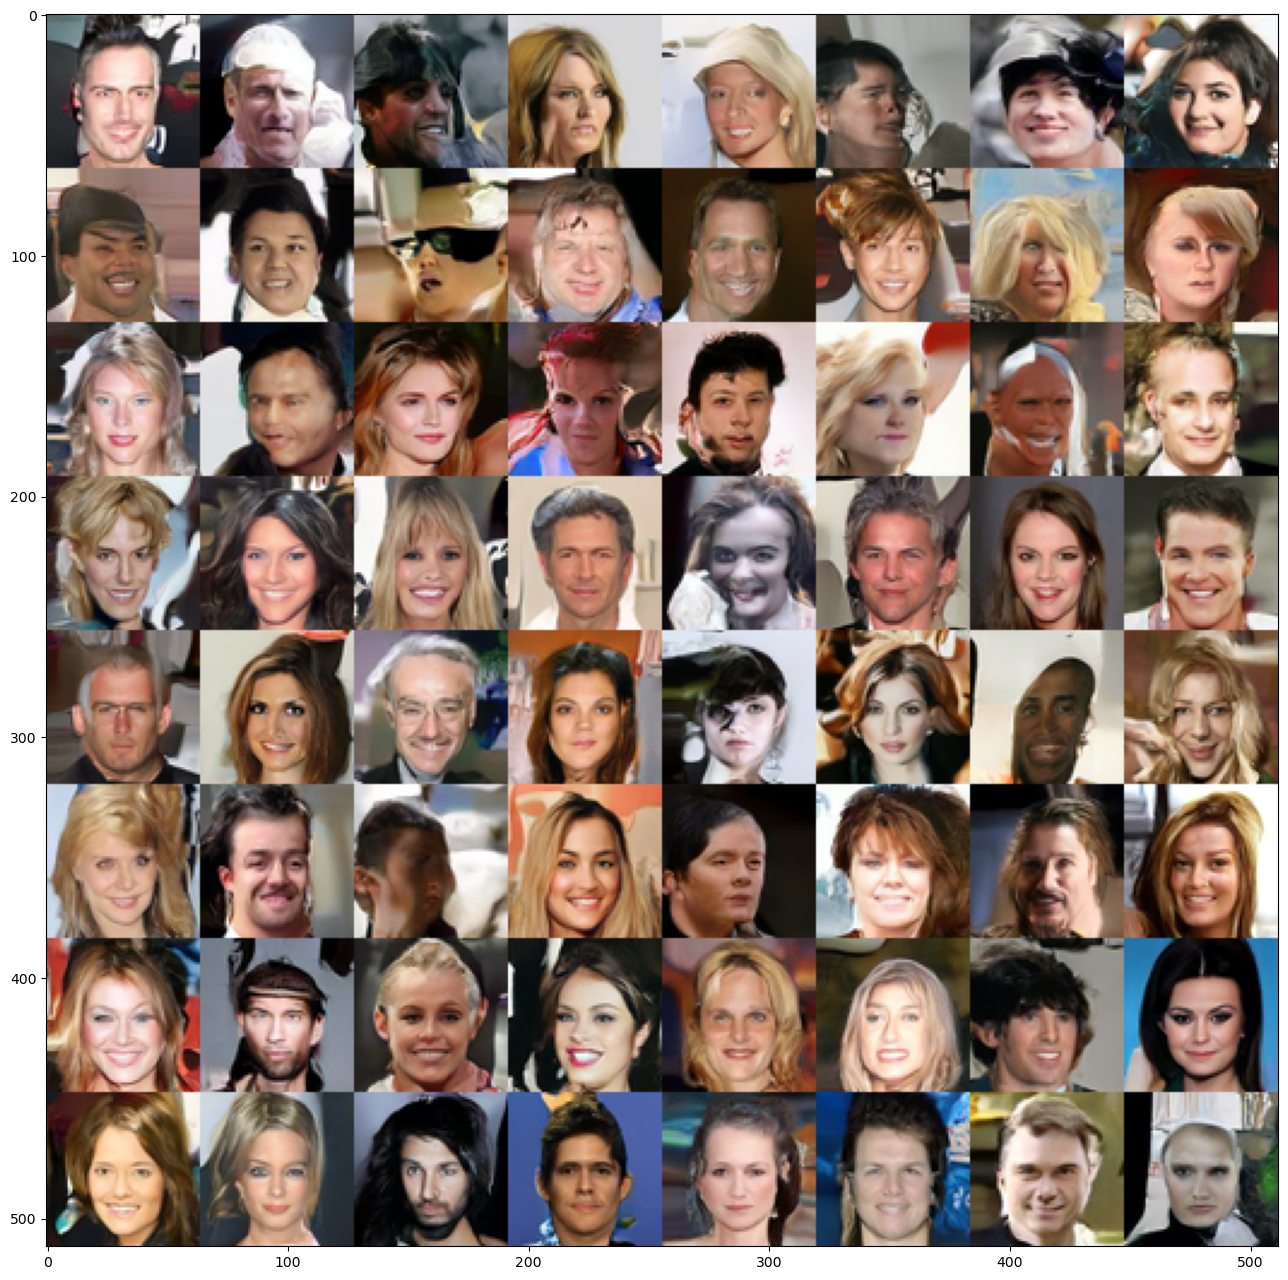

wandb: While tearing down the service manager. The following error has occured: [WinError 10054] An existing connection was forcibly closed by the remote host


In [28]:
grid = sample_lms(model_ema, size)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(grid)